In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import scipy.linalg
import scipy.stats
%matplotlib inline

# Maximum likelihood fit

Here we will look at a couple of problems and will code the maximum likelihood (ML) solution.

The key point for any maximum likelihoot fit is to write the likelihood function correctly.

Usually the likelihood function will look like this


```

def like(p, dataa, datab, ..):
    ...  
    return -loglike
    
```

It will take the vector of parameters p, various data and will return the minus log-likelihood

This log-likelihood can then be optimized by `scipy.optimize.minimize`

# Fitting an exponential distribution of arrival times

First let's code the problem from the lecture where our data is the set of arrival times (from some beta-decay experiment for example).

And we are trying to model those arrival times by the exponential distribution.

$$P(t|\tau) = \frac{1}{\tau} \exp(-\frac{t}{\tau})$$

The log-likelihood function will be the sum of  $\log(P(t_i|\tau)$ over all the data-points

Text(0.5, 0, 'Arrival times')

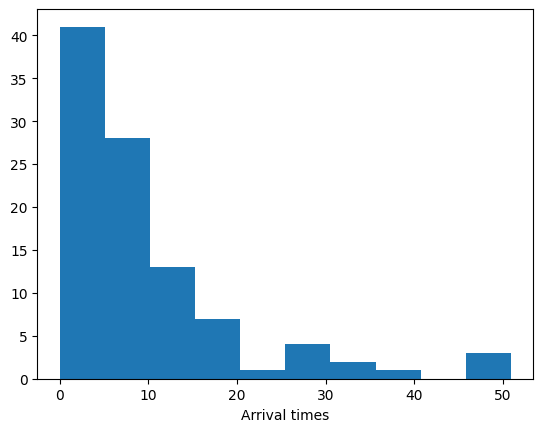

In [2]:
tau_true = 10


def gendata_exp(N):
    """ Return the times from the exponential distribution """
    return scipy.stats.expon(scale=tau_true).rvs(N)


TOBS = gendata_exp(100)

plt.hist(TOBS)
plt.xlabel('Arrival times')


In [3]:

def like1(p, TOBS):
    """
    return the -loglikelihood summed over all the data
    """

    tau = p[0]

    # This is the logarithm of
    # probability density of each data point under the exponential model
    log_pdf = np.log(1 / tau * np.exp(-TOBS / tau))
    # A better way to write it would be
    # -log(tau) - TOBS/tau
    # to avoid taking a logarithm of exp()
    loglike = log_pdf.sum()

    return -loglike

In [4]:

print('here are the optimization results')
res = scipy.optimize.minimize(like1, [1], args=(TOBS))
print(res)

print('our best fit tau is', res.x, 'the true one is ', tau_true)

here are the optimization results
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 327.9567846805678
        x: [ 9.772e+00]
      nit: 14
      jac: [-3.815e-06]
 hess_inv: [[ 9.563e-01]]
     nfev: 30
     njev: 15
our best fit tau is [9.77245493] the true one is  10


Now we use the maximum-likelihood approach and plot how the recovered parameter depends on
the number of points in the data (from 3 to 10000).

<ipython-input-5-719519caa463>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = res['x']


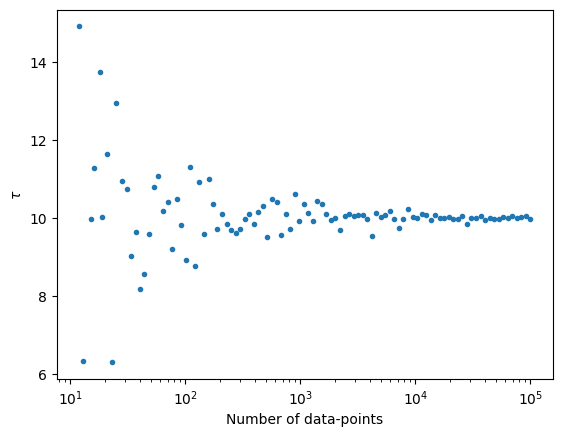

In [5]:
ndat = np.logspace(np.log(3), 5, 100).astype(int)
result = np.zeros(len(ndat))
for i, curn in enumerate(ndat):
    TOBS = gendata_exp(curn)
    res = scipy.optimize.minimize(like1, [1], args=(TOBS))
    result[i] = res['x']
plt.semilogx(ndat, result, '.')
plt.xlabel('Number of data-points')
plt.ylabel(r'$\tau$');


# Modeling a 2D distribution of points

Now we will fit a 2-D problem from the lecture.

Here we are modeling the distribution of particles on the detector by a Normal distribution

$$P(x,y | c_x, c_y ,s_x,s_y) = \frac{1}{2\pi s_x s_y} \exp\left(-\frac{1}{2}\frac{(x-c_x)^2}{s_x^2}-\frac{1}{2}\frac{(y-c_y)^2}{s_y^2}\right)$$

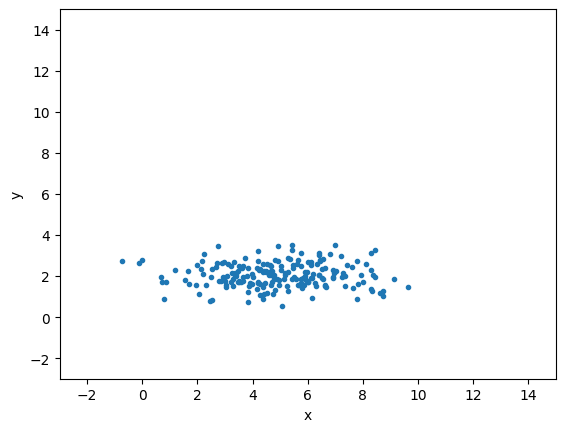

In [6]:
c_xtrue = 5
c_ytrue = 2
s_xtrue = 2
s_ytrue = .6


def gendata_2d(N, seed=1002232):
    rng = np.random.default_rng(seed)
    xs = rng.normal(c_xtrue, s_xtrue, N)
    ys = rng.normal(c_ytrue, s_ytrue, N)
    return xs, ys


X2d, Y2d = gendata_2d(200)
plt.plot(X2d, Y2d, '.')
plt.xlim(-3, 15)
plt.ylim(-3, 15)
plt.xlabel('x')
plt.ylabel('y');


Now we Write the likelihood function for this data
and fit the best values of $c_x$, $c_y$, $s_x$, $s_y$ using the maximum likelihood approach.

Remember the log-likelihood function should be the sum of log-probabilities for each data-point in your data.

Note : Instead of writing log(exp(-VAL)), it is more accurate to just substitute it by  -VAL

When you run the fit you may notice that you get a NaN results.
This is caused by the fact that if you evaluate your model for negative s_x that will lead to log(negative numbers).
To prevent this you may want to put in your function the code like:
```
if not np.isfinite(loglike):
    return 1e10
```
which will basically return a very large value if the loglikelihod function is not finite.
Alternatively you can also use the Nelder-mead optimization instead of BFGS.

In [7]:
def like2(p, x, y):
    """ Our likelihood function takes as input a parameter vector
    and the data (x,y)
    """
    c_x, c_y, s_x, s_y = p

    logp = np.log(
        1 / 2 / np.pi / s_x /
        s_y) - 0.5 * (x - c_x)**2 / s_x**2 - 0.5 * (y - c_y)**2 / s_y**2

    loglike = logp.sum()
    if not np.isfinite(loglike):
        return 1e10
    return -loglike


scipy.optimize.minimize(like2, [1, 1, 1, 1],
                        args=(X2d, Y2d))  #, method='Nelder-Mead')

<ipython-input-7-409f85ee94f9>:7: RuntimeWarning: invalid value encountered in log
  logp = np.log(


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 596.070860813656
        x: [ 4.906e+00  2.054e+00  1.964e+00  5.872e-01]
      nit: 26
      jac: [ 0.000e+00  0.000e+00 -7.629e-06  0.000e+00]
 hess_inv: [[ 1.462e-02 -4.492e-04  3.063e-04  1.162e-05]
            [-4.492e-04  1.693e-03 -1.258e-04 -1.357e-06]
            [ 3.063e-04 -1.258e-04  9.729e-03  9.615e-05]
            [ 1.162e-05 -1.357e-06  9.615e-05  8.290e-04]]
     nfev: 180
     njev: 36

# Uncertainties from the maximum likelihood fit
## Computing numerical derivatives and Hessian

To determine the uncertainties on the model parameters we need to determine the
matrix of second derivatives (or Hessian) of the log-likelihood function

To do that there is a nice package numdifftools https://numdifftools.readthedocs.io/en/latest/tutorials/getting_started.html

In [8]:
# We can install additional packages using a pip command
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.4 MB/s eta 0:00:00


In [9]:
import numdifftools

Here I demonstrate how we can determine the Hessian matrix (i.e. matrix of second derivatives) of the function
$$f(x) = x_0^2+ 3 x_1^2 + 4 x_2^4$$
at the location X=[0,0,0]
It should be equal to
$$\begin{pmatrix}
2 & 0 & 0\\
0 & 6 & 0\\
0 & 0 & 0\\
\end{pmatrix}
$$

In [10]:
def testfunc(p):
    return p[0]**2 + 3 * p[1]**2 + 4 * p[2]**4

HH = numdifftools.Hessian(testfunc)
print(HH([0, 0, 0]))

[[2.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 6.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.8265959e-19]]


Now use the `numdifftools` module to determine the Hessian matrix of the likelihood function in the minimum. To get the uncertainties you need to invert the matrix (`scipy.linalg.inv`), extract the diagonal from it and take the square root of that.

In [11]:
res = scipy.optimize.minimize(like2, [1, 1, 1, 1], args=(X2d, Y2d))

### BEGIN SOLUTION
def myfunc(p):
    return like2(p, X2d, Y2d)


cov = numdifftools.Hessian(myfunc)(res.x)
print(np.sqrt(np.diag(scipy.linalg.inv(cov))))
### END SOLUTION

[0.13886386 0.04152005 0.09819158 0.02935911]


<ipython-input-7-409f85ee94f9>:7: RuntimeWarning: invalid value encountered in log
  logp = np.log(


# Dimming light source problem

You are observing a faint distant object that is becoming fainter and fainter with time.

Your detector recorded the number of photons coming from the source when observed for 50 seconds
in time intervals of 1 second.

Text(0, 0.5, 'N photons')

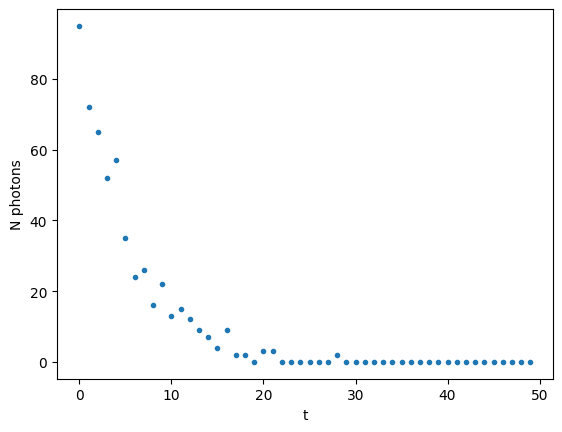

In [12]:
# This is our input data
# Showing the number of photons as a function of time

NPHOT = [
    95, 72, 65, 52, 57, 35, 24, 26, 16, 22, 13, 15, 12, 9, 7, 4, 9, 2, 2, 0, 3,
    3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0
]
TIMES = np.arange(len(NPHOT))
plt.plot(TIMES, NPHOT, '.')
plt.xlabel('t')
plt.ylabel('N photons')

# Problem

You believe that the source brightness is decaying exponentially $\exp(-t/\tau)$.

Assuming that the number of photons registered in each interval t can be described by Poisson
distribution with the rate parameter described by $N_0 \exp(-t/\tau)$, write the likelihood and estimate the parameter tau.

Your log-likelihood function needs to sum over all 50 observations.

Remember that you can  use `scipy.stats.poisson` and it's `pmf` method to estimate the likelihood of each observation.

Your model will need to have two parameters $N_0$ and $\tau$


Overplot your best-fit model on top of the data.

[96.86559989  5.110374  ]


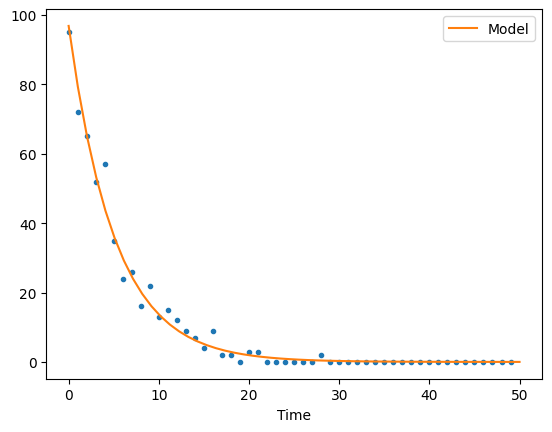

In [13]:
def like3(p, nphot):
    n0, tau = p
    N = len(nphot)
    P = scipy.stats.poisson(n0 * np.exp(-TIMES / tau))
    logp = np.log(P.pmf(nphot)).sum()
    return -logp


ret = scipy.optimize.minimize(like3, [4, 4], args=(NPHOT,))

print(ret['x'])
plt.plot(NPHOT, '.')
xgrid = np.linspace(0, 50)
plt.plot(xgrid, ret['x'][0] * np.exp(-xgrid / ret['x'][1]),label='Model');
plt.xlabel('Time')
plt.legend()

